In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import itertools

In [2]:
### Config
# project = "ar-extrapolate"
project = "lr-extrapolate"
# project = "gmm-extrapolate"

# use_cache = False
use_cache = True
# TOP_K_RUNS = 1000
TOP_K_RUNS = 1
STEP = "last"  # 'best', 'last', or 'tok32'

# when exporting from wandb, limit the number of runs for fast debugging
max_runs = 10000
# max_runs = 10

if project == "lr-extrapolate":
    DIFF = "data.curriculum.dims.end"
    XYS_TRAIN = "data.curriculum.points_train.end"
    XYS_VAL = "data.curriculum.points_val.end"
    METRIC = "Mean Squared Error"
    METRIC_TOK_VAL = "eval-eval.per_token_loss"
    METRIC_TOK_TEST = "eval-test.per_token_loss"
    METRIC_AVG_VAL = "eval-eval.loss"
    METRIC_AVG_TEST = "eval-test.loss"
    METRIC_MAX_MIN = "min"  # 'max' or 'min
    n_classes = [5, 10, 20]
elif project == "gmm-extrapolate":
    DIFF = "data.num_classes"
    XYS_TRAIN = "data.num_xy_pairs_train"
    XYS_VAL = "data.num_xy_pairs_val"
    METRIC = "Accuracy"
    METRIC_TOK_VAL = "eval-eval.per_token_acc"
    METRIC_TOK_TEST = "eval-test.per_token_acc"
    METRIC_AVG_VAL = "eval-eval.avg_acc"
    METRIC_AVG_TEST = "eval-test.avg_acc"
    METRIC_MAX_MIN = "max"  # 'max' or 'min
    n_classes = [2, 4, 8]
elif project == "ar-extrapolate":
    DIFF = "data.vocab_size"
    XYS_TRAIN = "data.num_xy_pairs_train"
    XYS_VAL = "data.num_xy_pairs_val"
    METRIC = "Accuracy"
    METRIC_TOK_VAL = "eval-eval.per_token_acc"
    METRIC_TOK_TEST = "eval-test.per_token_acc"
    METRIC_AVG_VAL = "eval-eval.avg_acc"
    METRIC_AVG_TEST = "eval-test.avg_acc"
    METRIC_MAX_MIN = "max"  # 'max' or 'min
    n_classes = [20, 30, 40]
else:
    raise ValueError(f"Unknown project: {project}")



states = ("finished",)
entity = "iceberg"
hist_cols = [
    METRIC_TOK_VAL,
    METRIC_TOK_TEST,
    METRIC_AVG_VAL,
    METRIC_AVG_TEST,
    "train.loss",
    "eval-eval.loss",
    "eval-test.loss",
]
if 'lr-extrapolate' in project:
    hist_cols = hist_cols[:4]
config_cols = ["model", DIFF, XYS_TRAIN]

In [3]:
def get_wandb_runs(entity, project):
    api = wandb.Api()
    runs = api.runs(f"{entity}/{project}")
    return runs

def extract_pow2_accs(x):
    pows = [int(2**i) - 1 for i in range(11)]
    extracted_accs = x[pows]
    return extracted_accs

def compute_avg_acc(x):
    return np.mean(x)

def build_fp(**kwargs):
    return "_".join([f"{k}={v}" for k, v in kwargs.items()]) + ".pkl"


def export_wandb_project(
    entity,
    project,
    config_cols,
    hist_cols,
    max_runs=None,
    states=("finished"),
    use_cache=False,
):
    fp = build_fp(entity=entity, project=project)
    if use_cache:
        try:
            print(f"Attempting to load cache file: {fp}")
            return pd.read_pickle(fp)
        except FileNotFoundError:
            print(f"Cache file not found: {fp}. Exporting from wandb.")
            pass

    runs = get_wandb_runs(entity, project)
    print(f"{runs[0].__dict__.keys()}=")
    run_data = []

    for run in tqdm(runs, desc="Exporting run data"):
        if (max_runs is not None) and (len(run_data) >= max_runs):
            break

        if run.state not in states:
            continue

        id = {"run_id": run.id, "sweep_id": str(run.sweep)}
        config = {k: run.config.get(k) for k in config_cols}
        config.update(id)
        hist = run.history(keys=hist_cols)

        # Combine all information and history data
        # combined_data = pd.concat([id, config, hist], axis=1)
        combined_data = hist.assign(**config)

        # Append the combined data to run_data list
        run_data.append(combined_data)

    # Combine all run data into a single DataFrame
    all_run_data = pd.concat(run_data, ignore_index=True)

    all_run_data.to_pickle(fp)
    return all_run_data


df = export_wandb_project(
    entity=entity,
    project=project,
    config_cols=config_cols,
    hist_cols=hist_cols,
    max_runs=max_runs,
    states=states,
    use_cache=use_cache,
)
print(df.shape)
df.head()

Attempting to load cache file: entity=iceberg_project=lr-extrapolate.pkl
(32907, 10)


,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,run_id,sweep_id
0,0,"[19.42481803894043, 20.826234817504883, 19.655...","[20.04945182800293, 20.95050811767578, 19.4878...",20.388803,20.582403,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...
1,5000,"[18.973012924194336, 20.3577880859375, 19.2099...","[19.545949935913086, 20.71651840209961, 19.187...",19.942589,20.157223,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...
2,10000,"[19.165870666503906, 20.09442710876465, 18.491...","[19.62596321105957, 20.050521850585938, 18.963...",16.398766,16.471390,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...
3,15000,"[19.11905860900879, 19.584367752075195, 17.753...","[19.615127563476562, 19.652000427246094, 18.29...",14.316841,14.336823,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...
4,20000,"[19.06728744506836, 19.28748321533203, 17.5155...","[19.637645721435547, 19.52585220336914, 17.787...",17.823328,17.818649,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...


In [4]:
# add column for token metric at index 32
df['val_metric_tok32'] = df[METRIC_TOK_VAL].apply(lambda x: x[31])
df['test_metric_tok32'] = df[METRIC_TOK_TEST].apply(lambda x: x[31])
df.head()

,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,run_id,sweep_id,val_metric_tok32,test_metric_tok32
0,0,"[19.42481803894043, 20.826234817504883, 19.655...","[20.04945182800293, 20.95050811767578, 19.4878...",20.388803,20.582403,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...,19.331963,20.841951
1,5000,"[18.973012924194336, 20.3577880859375, 19.2099...","[19.545949935913086, 20.71651840209961, 19.187...",19.942589,20.157223,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...,19.078978,20.326864
2,10000,"[19.165870666503906, 20.09442710876465, 18.491...","[19.62596321105957, 20.050521850585938, 18.963...",16.398766,16.471390,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...,13.112692,14.650328
3,15000,"[19.11905860900879, 19.584367752075195, 17.753...","[19.615127563476562, 19.652000427246094, 18.29...",14.316841,14.336823,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...,8.170067,9.047102
4,20000,"[19.06728744506836, 19.28748321533203, 17.5155...","[19.637645721435547, 19.52585220336914, 17.787...",17.823328,17.818649,mamba,20,32,qn6zujho,<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISH...,6.710688,7.348410


In [5]:
def pick_step(df, row_type, max_min):
    # group df by run_id
    grouped_df = df.groupby('run_id')
    
    if row_type == 'last':
        # only keep the last row of each group
        df = grouped_df.last()
        df = df.reset_index(drop=False)    
    elif row_type == 'best':
        # only keep the row with the highest "eval-eval.avg_acc"
        if max_min == 'max':
            df = grouped_df.apply(lambda x: x.loc[x[METRIC_AVG_VAL].idxmax()])
        elif max_min == 'min':
            df = grouped_df.apply(lambda x: x.loc[x[METRIC_AVG_VAL].idxmin()])
        else:
            raise ValueError(f"Invalid max_min: {max_min}")
    elif row_type == 'tok32':
        if max_min == 'max':
            df = grouped_df.apply(lambda x: x.loc[x['val_metric_tok32'].idxmax()])
        elif max_min == 'min':
            df = grouped_df.apply(lambda x: x.loc[x['val_metric_tok32'].idxmin()])
    else:
        raise ValueError(f"Invalid row_type: {row_type}")

    # clean up the index
    
    return df
    
df_step = pick_step(df, row_type=STEP, max_min=METRIC_MAX_MIN)
print(df_step.shape)
df_step.head()

(1567, 12)


,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,sweep_id,val_metric_tok32,test_metric_tok32
0,01osi9tt,100000,"[30.815719604492188, 29.010263442993164, 24.71...","[28.882312774658203, 26.3458251953125, 29.1330...",41.477604,41.381504,hyena,30,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,11.427915,12.251956
1,01sookg5,100000,"[18.93607521057129, 20.384294509887695, 19.237...","[19.520227432250977, 20.73011016845703, 19.162...",19.943567,20.154739,lightconv,20,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,19.082407,20.326181
2,04pdcei1,100000,"[18.960041046142578, 19.70029067993164, 18.468...","[19.575969696044922, 20.00877571105957, 18.344...",16.938025,17.174641,rnn,20,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,16.333439,17.249477
3,061o84vz,100000,"[30.778594970703125, 30.218767166137695, 26.81...","[28.848966598510742, 27.30132484436035, 30.752...",28.971861,28.949299,s4,30,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,30.558571,29.435934
4,072wistj,100000,"[18.97172737121582, 19.150623321533203, 17.850...","[19.52452850341797, 19.6444034576416, 18.06876...",24.519102,24.858915,s4,20,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,12.204028,13.371013


In [6]:
df_step['model'].value_counts()

model
lightconv      135
rnn            135
s4             135
gru            135
lstm           135
dynamicconv    135
hyena          108
gpt2           108
rwkv           108
llama2         108
h3             108
retnet         108
mamba           81
mega            24
reformer         4
Name: count, dtype: int64

In [7]:
df_step['sweep_id'].value_counts()

sweep_id
<Sweep iceberg/lr-extrapolate/vln442rl (FINISHED)>    891
<Sweep iceberg/lr-extrapolate/eoefmgml (FINISHED)>    297
<Sweep iceberg/lr-extrapolate/jxt5wdqb (FINISHED)>     81
<Sweep iceberg/lr-extrapolate/2gx6j34n (FINISHED)>     81
<Sweep iceberg/lr-extrapolate/idjpijto (FINISHED)>     81
<Sweep iceberg/lr-extrapolate/pflba0wu (PAUSED)>       28
<Sweep iceberg/lr-extrapolate/lehesnsr (FINISHED)>     27
<Sweep iceberg/lr-extrapolate/45l60q6x (FINISHED)>     27
<Sweep iceberg/lr-extrapolate/dkhy5boy (FINISHED)>     27
<Sweep iceberg/lr-extrapolate/z14fxt6b (FINISHED)>     27
Name: count, dtype: int64

In [8]:
df_step['_step'].value_counts()

_step
100000    1567
Name: count, dtype: int64

In [9]:
# check for nan losses
df_step['eval-eval.loss'] = df_step['eval-eval.loss'].apply(lambda x: float(x))
_ = df_step.sort_values(by='eval-eval.loss', ascending=True)
_["eval-eval.loss"].head()

1067    0.015378
617     0.015461
762     0.015480
931     0.015535
524     0.015752
Name: eval-eval.loss, dtype: float64

In [10]:
_["eval-eval.loss"].tail()

1137    164.285004
804     194.201950
84      199.584000
358     245.904434
1466    248.924850
Name: eval-eval.loss, dtype: float64

In [11]:
# sort training runs by performance, here we use the run with the best
# validation score at token 32, the longest sequence seen during training
def top_k_rows(group, k, metric_column, min_max):
    if min_max == "max":
        return group.nlargest(k, metric_column)
    elif min_max == "min":
        return group.nsmallest(k, metric_column)
    else:
        raise ValueError(f"Invalid min_max: {min_max}")


grouped = (
    df_step.groupby(["model", DIFF, XYS_TRAIN])
    .apply(
        top_k_rows,
        k=TOP_K_RUNS,
        metric_column="val_metric_tok32",
        min_max=METRIC_MAX_MIN,
    )
    .reset_index(drop=True)
)
grouped.head()

,run_id,_step,eval-eval.per_token_loss,eval-test.per_token_loss,eval-eval.loss,eval-test.loss,model,data.curriculum.dims.end,data.curriculum.points_train.end,sweep_id,val_metric_tok32,test_metric_tok32
0,1dsr7lp9,100000,"[4.978780746459961, 3.6092512607574463, 3.0355...","[4.928627967834473, 3.8314008712768555, 3.2382...",0.021464,0.021784,dynamicconv,5,32,<Sweep iceberg/lr-extrapolate/eoefmgml (FINISH...,0.006787,0.006659
1,wgci8yt4,100000,"[9.99402141571045, 9.336719512939453, 8.202196...","[9.689234733581543, 8.992465019226074, 8.23466...",0.390574,0.383061,dynamicconv,10,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,0.405826,0.429020
2,hyz0cy71,100000,"[18.969430923461914, 19.590845108032227, 18.53...","[19.502504348754883, 20.081106185913086, 18.84...",15.052264,15.036098,dynamicconv,20,32,<Sweep iceberg/lr-extrapolate/idjpijto (FINISH...,14.951179,16.412254
3,fpn1mkf9,100000,"[30.795942306518555, 29.947988510131836, 26.58...","[28.901123046875, 27.411457061767578, 30.67814...",28.522762,28.558571,dynamicconv,30,32,<Sweep iceberg/lr-extrapolate/vln442rl (FINISH...,29.609718,29.726751
4,zy9cftba,100000,"[4.981224060058594, 3.624082088470459, 3.04067...","[4.9275078773498535, 3.8419551849365234, 3.222...",4.822925,4.904863,gpt2,5,32,<Sweep iceberg/lr-extrapolate/eoefmgml (FINISH...,0.000202,0.000187


In [12]:
grouped['model'].value_counts()

model
dynamicconv    4
gpt2           4
gru            4
h3             4
hyena          4
lightconv      4
llama2         4
lstm           4
retnet         4
rnn            4
rwkv           4
s4             4
mamba          3
mega           1
reformer       1
Name: count, dtype: int64

In [13]:
def agg_df(grouped):
    grouped = grouped.groupby(['model', DIFF, XYS_TRAIN]).agg({METRIC_TOK_VAL: list, METRIC_TOK_TEST: list, '_step': list, 'val_metric_tok32': list, 'test_metric_tok32': list})
    grouped[METRIC_TOK_VAL] = grouped[METRIC_TOK_VAL].apply(lambda x: np.mean(np.array(x), axis=0))
    grouped[METRIC_TOK_TEST] = grouped[METRIC_TOK_TEST].apply(lambda x: np.mean(np.array(x), axis=0))
    return grouped

df_agg = agg_df(grouped)
df_agg = df_agg.reset_index()
print(df_agg.shape)
df_agg.head()

(53, 8)


,model,data.curriculum.dims.end,data.curriculum.points_train.end,eval-eval.per_token_loss,eval-test.per_token_loss,_step,val_metric_tok32,test_metric_tok32
0,dynamicconv,5,32,"[4.978780746459961, 3.6092512607574463, 3.0355...","[4.928627967834473, 3.8314008712768555, 3.2382...",[100000],[0.006787425372749567],[0.00665863323956728]
1,dynamicconv,10,32,"[9.99402141571045, 9.336719512939453, 8.202196...","[9.689234733581543, 8.992465019226074, 8.23466...",[100000],[0.40582552552223206],[0.42901965975761414]
2,dynamicconv,20,32,"[18.969430923461914, 19.590845108032227, 18.53...","[19.502504348754883, 20.081106185913086, 18.84...",[100000],[14.951178550720215],[16.412254333496094]
3,dynamicconv,30,32,"[30.795942306518555, 29.947988510131836, 26.58...","[28.901123046875, 27.411457061767578, 30.67814...",[100000],[29.609718322753906],[29.72675132751465]
4,gpt2,5,32,"[4.981224060058594, 3.624082088470459, 3.04067...","[4.9275078773498535, 3.8419551849365234, 3.222...",[100000],[0.0002018030936596915],[0.00018748565344139934]


In [14]:
def post_process(df):
    df = df.copy()
    # df['per_token_acc'] = df['per_token_acc'].apply(np.array)
    df['val_tok_len'] = df[METRIC_TOK_VAL].apply(len)
    df['test_tok_len'] = df[METRIC_TOK_TEST].apply(len)
    
    df['val_tok_pow2'] = df[METRIC_TOK_VAL].apply(extract_pow2_accs)
    df['test_tok_pow2'] = df[METRIC_TOK_TEST].apply(extract_pow2_accs)

    df['val_tok_pow2_len'] = df['val_tok_pow2'].apply(len)
    df['test_tok_pow2_len'] = df['test_tok_pow2'].apply(len)
    
    df['val_avg_acc'] = df[METRIC_TOK_VAL].apply(compute_avg_acc)
    df['test_avg_acc'] = df[METRIC_TOK_TEST].apply(compute_avg_acc)
    
    return df
df_agg = post_process(df_agg)
df_agg.head()

,model,data.curriculum.dims.end,data.curriculum.points_train.end,eval-eval.per_token_loss,eval-test.per_token_loss,_step,val_metric_tok32,test_metric_tok32,val_tok_len,test_tok_len,val_tok_pow2,test_tok_pow2,val_tok_pow2_len,test_tok_pow2_len,val_avg_acc,test_avg_acc
0,dynamicconv,5,32,"[4.978780746459961, 3.6092512607574463, 3.0355...","[4.928627967834473, 3.8314008712768555, 3.2382...",[100000],[0.006787425372749567],[0.00665863323956728],1024,1024,"[4.978780746459961, 3.6092512607574463, 1.9850...","[4.928627967834473, 3.8314008712768555, 1.9335...",11,11,0.021464,0.021784
1,dynamicconv,10,32,"[9.99402141571045, 9.336719512939453, 8.202196...","[9.689234733581543, 8.992465019226074, 8.23466...",[100000],[0.40582552552223206],[0.42901965975761414],1024,1024,"[9.99402141571045, 9.336719512939453, 7.322597...","[9.689234733581543, 8.992465019226074, 7.37098...",11,11,0.390574,0.383061
2,dynamicconv,20,32,"[18.969430923461914, 19.590845108032227, 18.53...","[19.502504348754883, 20.081106185913086, 18.84...",[100000],[14.951178550720215],[16.412254333496094],1024,1024,"[18.969430923461914, 19.590845108032227, 17.85...","[19.502504348754883, 20.081106185913086, 18.75...",11,11,15.052264,15.036098
3,dynamicconv,30,32,"[30.795942306518555, 29.947988510131836, 26.58...","[28.901123046875, 27.411457061767578, 30.67814...",[100000],[29.609718322753906],[29.72675132751465],1024,1024,"[30.795942306518555, 29.947988510131836, 27.61...","[28.901123046875, 27.411457061767578, 30.40090...",11,11,28.522763,28.558573
4,gpt2,5,32,"[4.981224060058594, 3.624082088470459, 3.04067...","[4.9275078773498535, 3.8419551849365234, 3.222...",[100000],[0.0002018030936596915],[0.00018748565344139934],1024,1024,"[4.981224060058594, 3.624082088470459, 1.97017...","[4.9275078773498535, 3.8419551849365234, 1.922...",11,11,4.822925,4.904864


In [15]:
to_save = df_agg[df_agg['data.curriculum.dims.end'] == 20]
# export dataframe as dataframe
to_save.to_pickle("df_agg_lr_20.pkl")


In [16]:
# only show these columns: data.num_classes, data.num_xy_pairs_train, val_tok_pow2, test_tok_pow2
# dont truncate column width
pd.set_option('display.max_colwidth', None)
df_agg[[DIFF, XYS_TRAIN, 'val_tok_pow2', 'test_tok_pow2', 'val_metric_tok32', 'test_metric_tok32']].head()

,data.curriculum.dims.end,data.curriculum.points_train.end,val_tok_pow2,test_tok_pow2,val_metric_tok32,test_metric_tok32
0,5,32,"[4.978780746459961, 3.6092512607574463, 1.9850409030914307, 0.06879038363695145, 0.010534083470702171, 0.006787425372749567, 0.006881596054881811, 0.006378447636961937, 0.007013348862528801, 0.00635450379922986, 0.006213497370481491]","[4.928627967834473, 3.8314008712768555, 1.933558702468872, 0.05734049156308174, 0.010974644683301449, 0.00665863323956728, 0.0063340915367007256, 0.006610550917685032, 0.005901933182030916, 0.007165537215769291, 0.005431646481156349]",[0.006787425372749567],[0.00665863323956728]
1,10,32,"[9.99402141571045, 9.336719512939453, 7.322597980499268, 4.0615034103393555, 1.6532845497131348, 0.40582552552223206, 0.3215694725513458, 0.3127017319202423, 0.3148821294307709, 0.2942506968975067, 0.31509262323379517]","[9.689234733581543, 8.992465019226074, 7.370980739593506, 4.085951805114746, 1.5091112852096558, 0.42901965975761414, 0.28363037109375, 0.3051890432834625, 0.31800660490989685, 0.33072543144226074, 0.32888108491897583]",[0.40582552552223206],[0.42901965975761414]
2,20,32,"[18.969430923461914, 19.590845108032227, 17.851097106933594, 17.778154373168945, 15.74713134765625, 14.951178550720215, 15.094137191772461, 14.726545333862305, 15.505844116210938, 14.35023307800293, 14.58209228515625]","[19.502504348754883, 20.081106185913086, 18.75826072692871, 18.40277671813965, 16.58310317993164, 16.412254333496094, 14.393692016601562, 14.042215347290039, 15.631102561950684, 14.179668426513672, 14.592794418334961]",[14.951178550720215],[16.412254333496094]
3,30,32,"[30.795942306518555, 29.947988510131836, 27.61797523498535, 30.400428771972656, 30.578737258911133, 29.609718322753906, 29.12303352355957, 29.671459197998047, 30.100223541259766, 26.999059677124023, 27.767271041870117]","[28.901123046875, 27.411457061767578, 30.400903701782227, 28.150306701660156, 27.774219512939453, 29.72675132751465, 27.28641700744629, 25.36404800415039, 28.428220748901367, 29.19659423828125, 29.595781326293945]",[29.609718322753906],[29.72675132751465]
4,5,32,"[4.981224060058594, 3.624082088470459, 1.9701714515686035, 0.0012960844906046987, 0.0002786312543321401, 0.0002018030936596915, 3.0457980632781982, 3.590407133102417, 4.174668312072754, 5.417779922485352, 5.7093634605407715]","[4.9275078773498535, 3.8419551849365234, 1.9223552942276, 0.0016772496746852994, 0.00029755913419649005, 0.00018748565344139934, 3.1999008655548096, 3.7594921588897705, 4.120306015014648, 5.717907428741455, 5.967618465423584]",[0.0002018030936596915],[0.00018748565344139934]


In [17]:
style_map = {
    'rnn': {'color': '#1f77b4', 'linestyle': 'solid', 'marker': 'o'},  # Solid line, circle marker
    'lstm': {'color': '#1f77b4', 'linestyle': '--', 'marker': 's'},  # Dashed line, square marker
    'gru': {'color': '#1f77b4', 'linestyle': ':', 'marker': '^'},  # Dash-dot line, triangle up marker

    'lightconv': {'color': '#ff7f0e', 'linestyle': 'solid', 'marker': 'D'},  # Solid line, diamond marker
    'dynamicconv': {'color': '#ff7f0e', 'linestyle': '--', 'marker': 'v'},  # Dashed line, triangle down marker

    's4': {'color': '#2ca02c', 'linestyle': 'solid', 'marker': '<'},  # Solid line, triangle left marker
    'h3': {'color': '#2ca02c', 'linestyle': '--', 'marker': '>'},  # Dashed line, triangle right marker
    'hyena': {'color': '#2ca02c', 'linestyle': '-.', 'marker': 'p'},  # Dash-dot line, pentagon marker
    'mamba': {'color': '#2ca02c', 'linestyle': ':', 'marker': 'X'},  # Dotted line, x marker

    'llama2': {'color': '#d62728', 'linestyle': '--', 'marker': 'H'},  # Dashed line, hexagon marker
    'gpt2': {'color': '#d62728', 'linestyle': 'solid', 'marker': '*'},  # Dash-dot line, star marker

    'retnet': {'color': '#9467bd', 'linestyle': 'solid', 'marker': 'P'},  # Solid line, plus (filled) marker
    'rwkv': {'color': '#9467bd', 'linestyle': '--', 'marker': '^'},  # Dashed line, vertical line marker
}

legend_order = ['rnn', 'lstm', 'gru', 'lightconv', 'dynamicconv', 's4', 'h3', 'hyena', 'mamba', 'retnet', 'rwkv', 'gpt2', 'llama2']

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


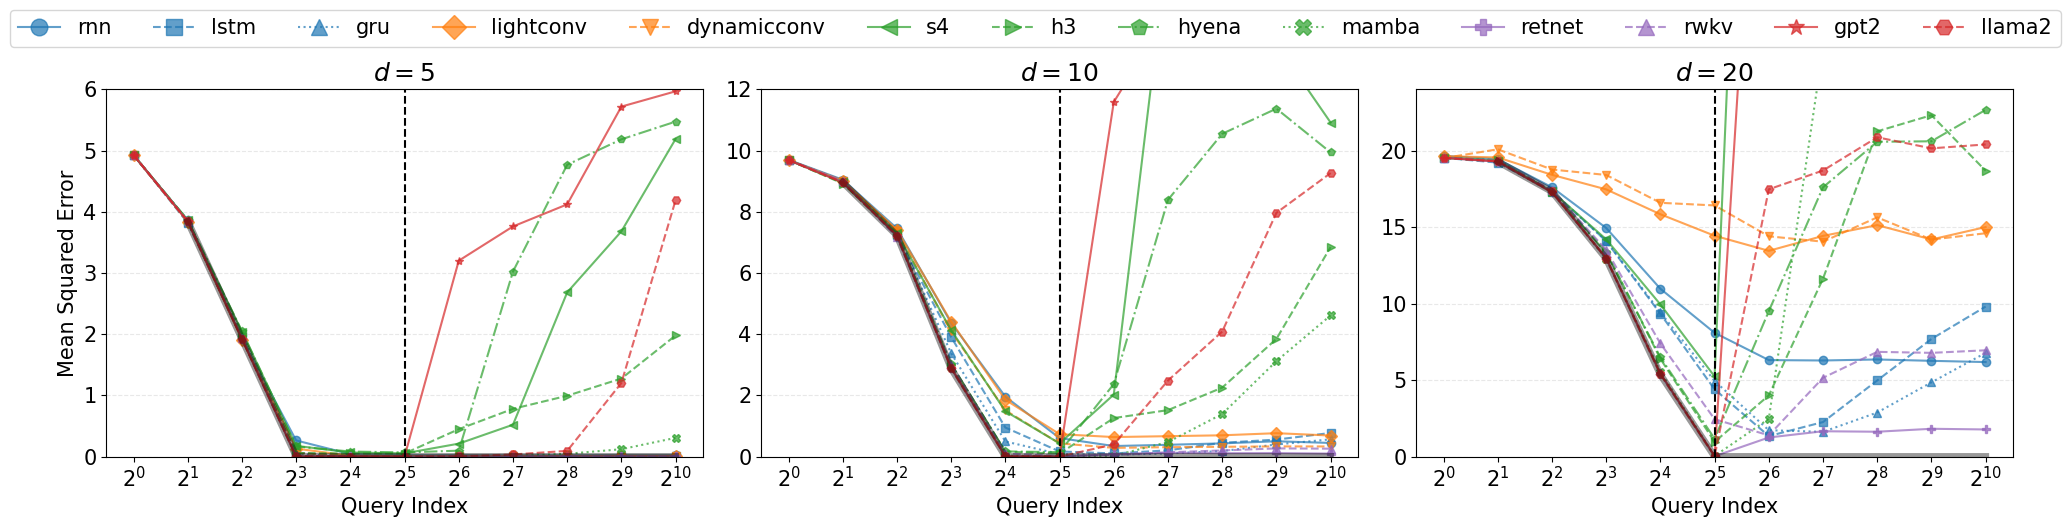

In [18]:
def plot(ax, df, n_classes=2, val_test='val', is_first_subplot=False):
    # fig, ax = plt.subplots()

    if val_test == 'val':
        col_to_plot = 'val_tok_pow2'
    elif val_test == 'test':
        col_to_plot = 'test_tok_pow2'
    else:
        raise ValueError(f"Invalid val_test: {val_test}")

    # filter df to only include n_classes
    df = df[df[DIFF] == n_classes]

    for model in legend_order:
    # for idx, row in df.iterrows():
        row = df[df['model'] == model].iloc[0]
        # model = row['model']
        style_args = style_map[model]
        ax.plot(
            row[col_to_plot],
            label=f"{row['model']}",
            alpha=0.7,
            **style_args,
        )

    # baselines
    if project == 'gmm-extrapolate':
        baseline = {
            2: [0.493, 0.626, 0.729, 0.798, 0.833, 0.874, 0.9, 0.924, 0.921, 0.935, 0.937],
            4: [0.26, 0.336, 0.438, 0.513, 0.599, 0.669, 0.766, 0.791, 0.818, 0.849, 0.864],
            8: [0.12, 0.181, 0.21, 0.289, 0.357, 0.449, 0.541, 0.618, 0.667, 0.707, 0.727],
        }
        # plot basline according to n_classes
        ax.plot(baseline[n_classes], color="black", linestyle="-", alpha=0.4, linewidth=5)
    elif project == 'lr-extrapolate':
        baseline = {
            5: [np.nan, 3.84279, 1.92143, 0.00277, 1e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            10: [np.nan, 8.96143, 7.22825, 2.87742, 0.00041, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            20: [np.nan, 19.27738, 17.31752, 12.93573, 5.3514, 9e-05, 0.0, 0.0, 0.0, 0.0, 0.0],
        }
        ax.plot(baseline[n_classes], color="black", linestyle="-", alpha=0.4, linewidth=5)
    else:
        pass
    
    # draw a dotted vertical line at n_xy_train
    v_idx = int(np.log2(row[XYS_TRAIN]))
    ax.axvline(x=v_idx, linestyle="--", color="black")

    # Add faint horizontal grid lines
    ax.yaxis.grid(True, linestyle="--", which="major", color="lightgrey", alpha=0.5)

    # Set x axis to powers of 2^0 ... 2^10
    ax.set_xticks(range(0, 11))
    ax.set_xticklabels([f"$2^{{{i}}}$" for i in range(11)])

    # set y min max to 0 and 1
    if project in ['ar-extrapolate', 'gmm-extrapolate']:
        ax.set_ylim([0, 1])
    elif project == 'lr-extrapolate':
        if n_classes == 5:
            ax.set_ylim(0, 5*1.2)
        elif n_classes == 10:
            ax.set_ylim(0, 10*1.2)
        elif n_classes == 20:
            ax.set_ylim(0, 20*1.2)

    # set title and labels
    title = f"task={project.split('-')[0]}, split={val_test}, classes={n_classes}, train_xys={row[XYS_TRAIN]}, step={STEP}, runs={TOP_K_RUNS}"
    print(title)
    ax.set_xlabel("Query Index")
    # Set y-axis label only on the first subplot
    if is_first_subplot:
        ax.set_ylabel(METRIC)

    if project == 'lr-extrapolate':
        title = f"$d={n_classes}$"
    elif project == 'ar-extrapolate':
        title = f"$|V|={n_classes}$"
    elif project == 'gmm-extrapolate':
        title = f"$k={n_classes}$"
    ax.set_title(title)

plt.rcParams.update({'font.size': 15})
fig, axes = plt.subplots(1, len(n_classes), figsize=(20, 5))
# Use the plot function inside a loop for all class counts you want to plot
for i, n_class in enumerate(n_classes):
    plot(axes[i], df_agg, n_classes=n_class, val_test='test', is_first_subplot=(i==0))  # Pass the appropriate axes

handles, labels = axes[0].get_legend_handles_labels()
# for h in handles:
#     h.set_markersize(5)
fig.legend(handles, labels, loc='upper center', ncol=len(df_agg['model'].unique()), bbox_to_anchor=(0.5, 1.08), markerscale=2)
# make the markers larger in the legend

plt.tight_layout()
plt.show()

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


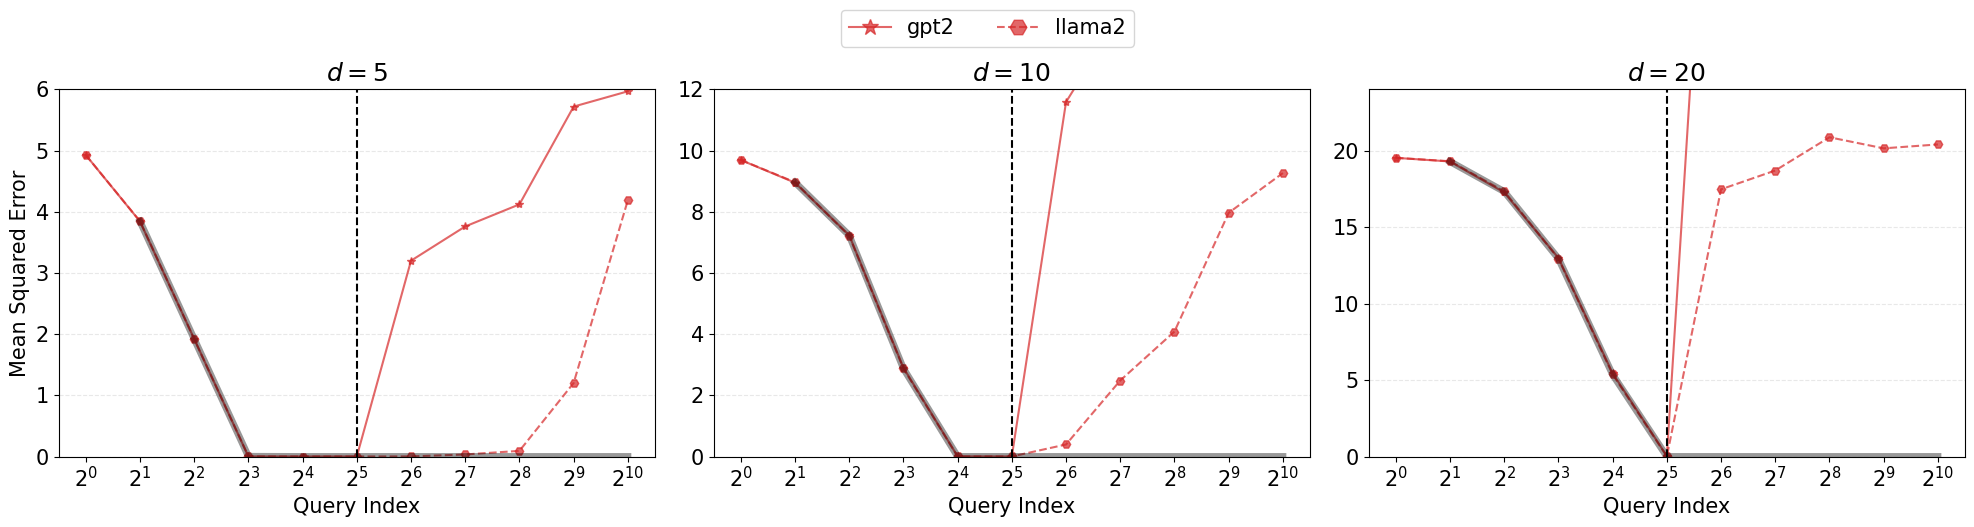

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


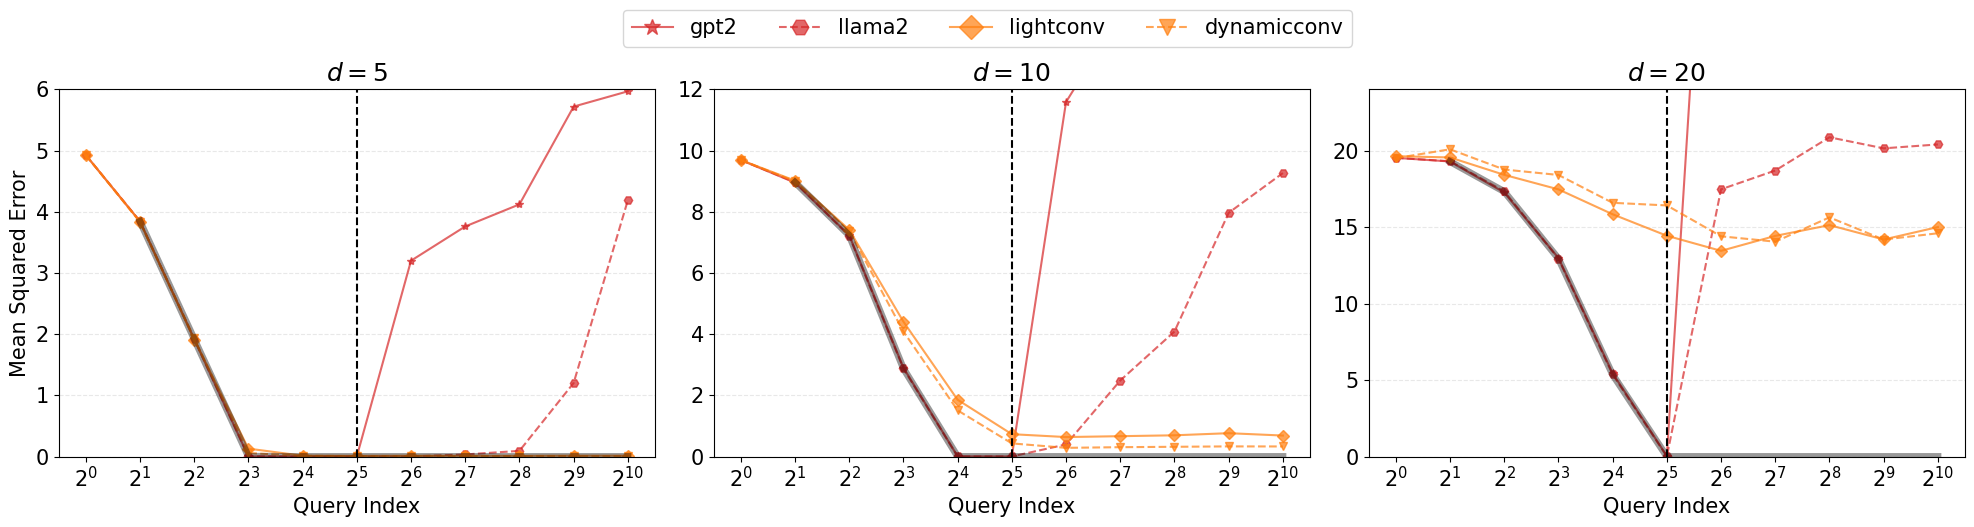

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


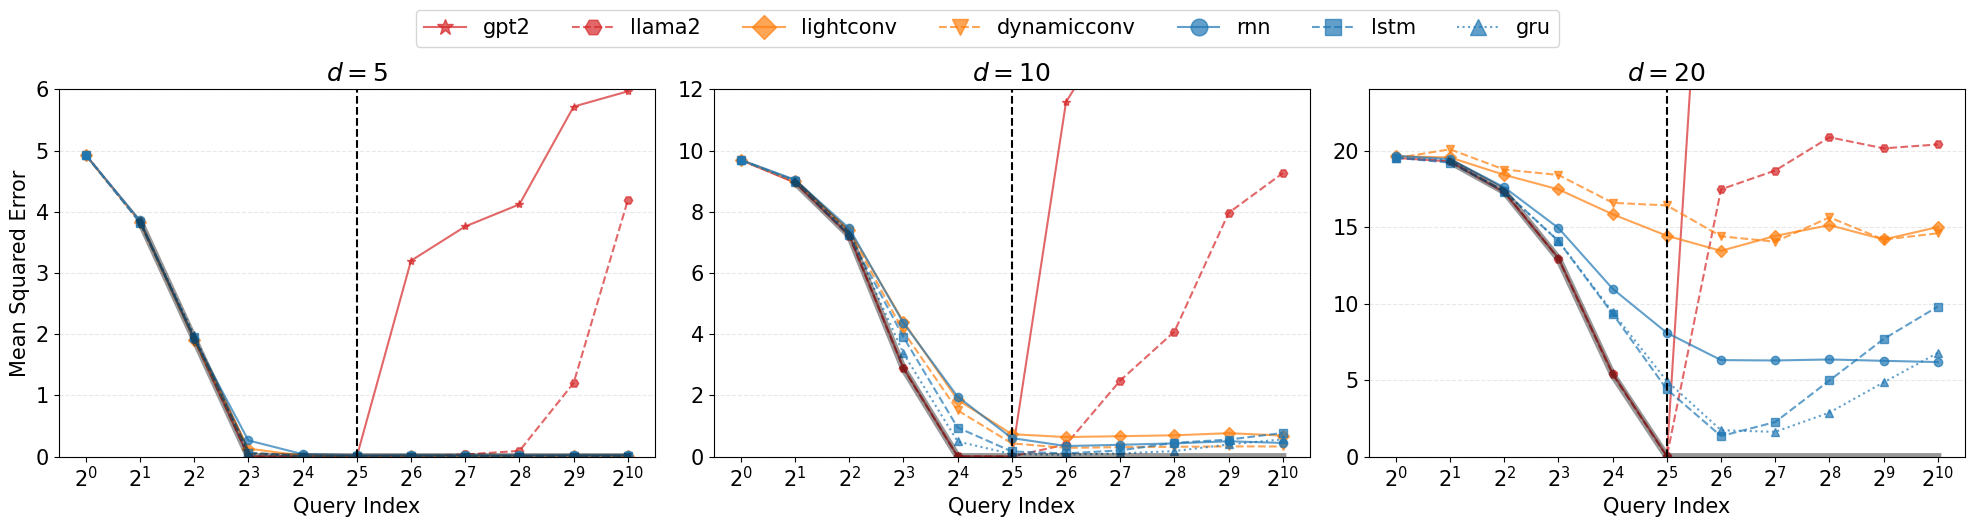

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


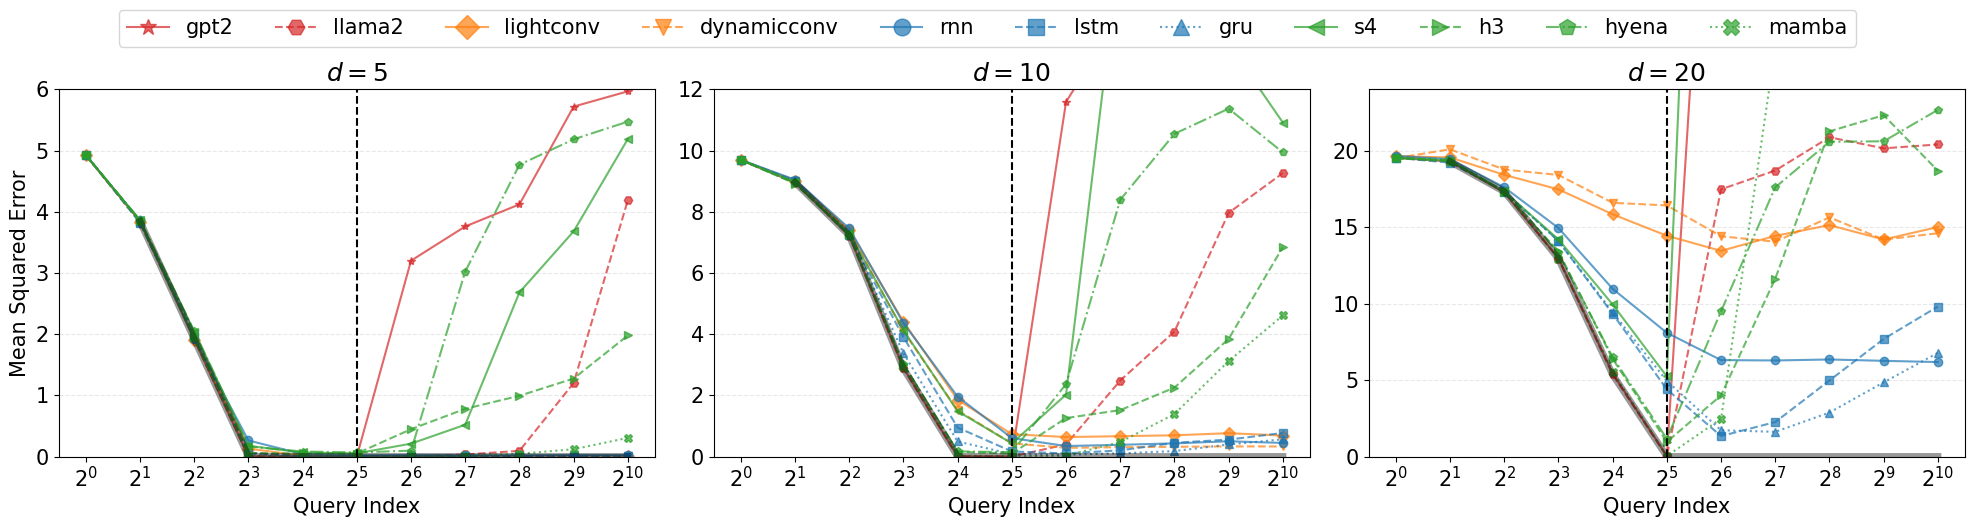

task=lr, split=test, classes=5, train_xys=32, step=last, runs=1
task=lr, split=test, classes=10, train_xys=32, step=last, runs=1
task=lr, split=test, classes=20, train_xys=32, step=last, runs=1


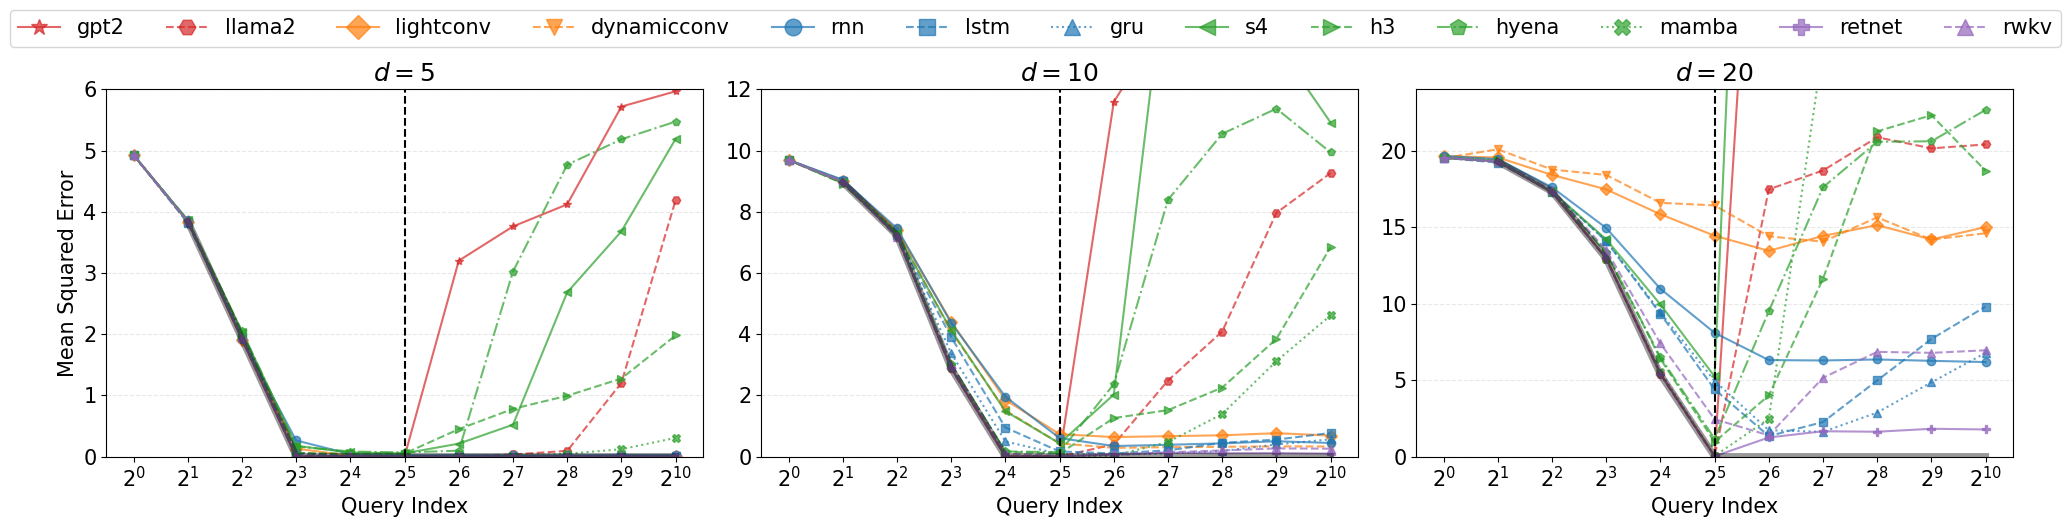

In [19]:
transformers = ['gpt2', 'llama2']
rnns = ['rnn', 'lstm', 'gru']
cnns = ['lightconv', 'dynamicconv']
ssms = ['s4', 'h3', 'hyena', 'mamba']
attalts = ['retnet', 'rwkv']
legend_order = []
for family in [transformers, cnns, rnns, ssms, attalts]:
    legend_order += family

    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(1, len(n_classes), figsize=(20, 5))
    # Use the plot function inside a loop for all class counts you want to plot
    for i, n_class in enumerate(n_classes):
        plot(axes[i], df_agg, n_classes=n_class, val_test='test', is_first_subplot=(i==0))  # Pass the appropriate axes

    handles, labels = axes[0].get_legend_handles_labels()
    # for h in handles:
    #     h.set_markersize(5)
    fig.legend(handles, labels, loc='upper center', ncol=len(df_agg['model'].unique()), bbox_to_anchor=(0.5, 1.08), markerscale=2)
    # make the markers larger in the legend

    plt.tight_layout()
    plt.show()

task=lr, split=test, classes=5, step=last, runs=1


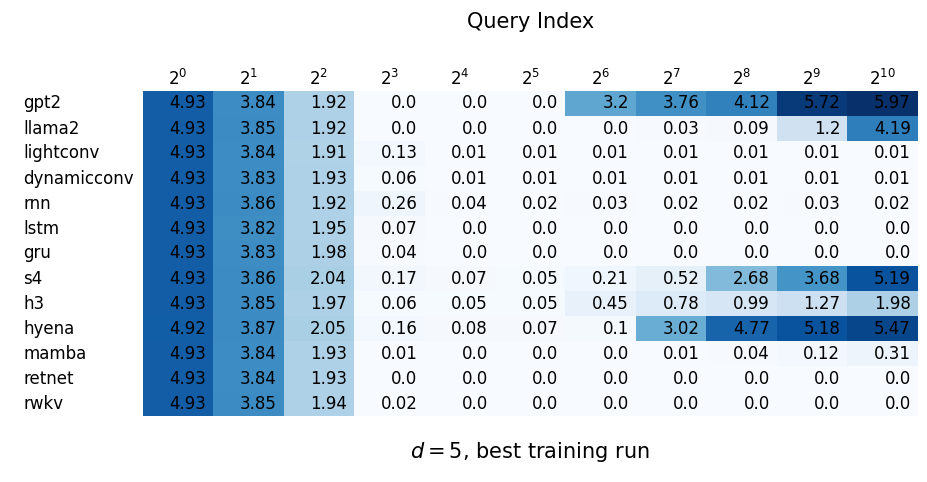

task=lr, split=test, classes=10, step=last, runs=1


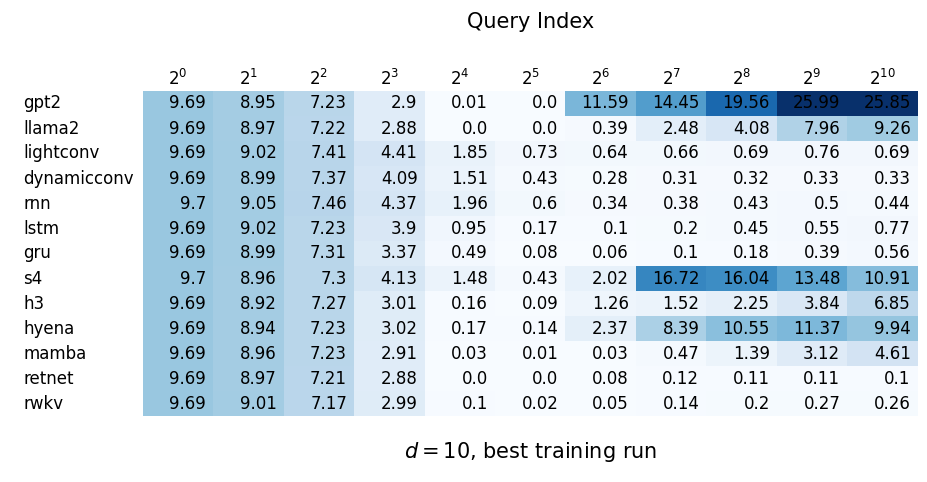

task=lr, split=test, classes=20, step=last, runs=1


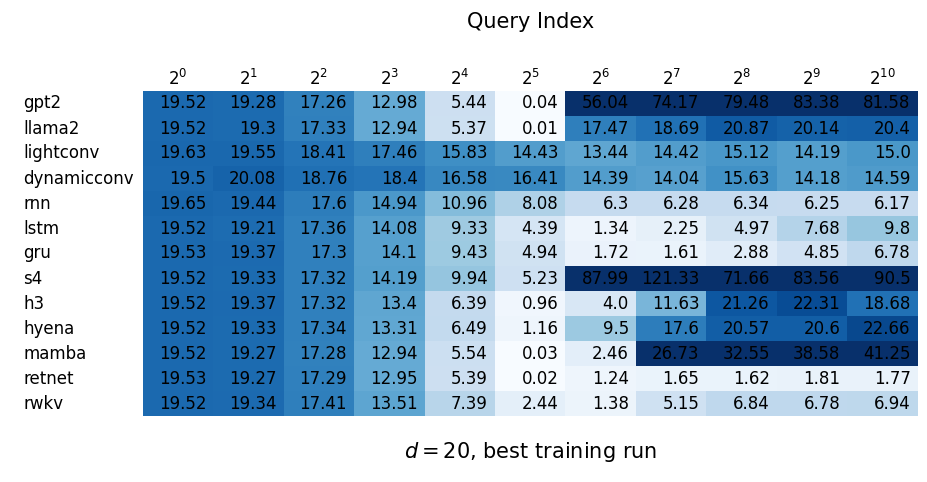

In [20]:
def acc_vs_tkn_idx(df, n_classes=20):
    # Filter dataframe for the given number of classes and make a copy to avoid SettingWithCopyWarning
    df_filtered = df[df[DIFF] == n_classes].copy()

    # Perform operations on the copy to compute lengths and average accuracies
    df_filtered.loc[:, 'val_tok_len'] = df_filtered[METRIC_TOK_VAL].str.len()
    df_filtered.loc[:, 'test_tok_len'] = df_filtered[METRIC_TOK_TEST].str.len()
    
    # Extract power of 2 accuracies and compute lengths
    df_filtered.loc[:, 'val_tok_pow2'] = df_filtered[METRIC_TOK_VAL].apply(extract_pow2_accs)
    df_filtered.loc[:, 'test_tok_pow2'] = df_filtered[METRIC_TOK_TEST].apply(extract_pow2_accs)

    # Compute average accuracies
    df_filtered.loc[:, 'val_avg_acc'] = df_filtered[METRIC_TOK_VAL].apply(compute_avg_acc)
    df_filtered.loc[:, 'test_avg_acc'] = df_filtered[METRIC_TOK_TEST].apply(compute_avg_acc)

    # Determine the max length for token indices to set table column size
    max_len = df_filtered['test_tok_pow2_len'].max()
    df_new = pd.DataFrame(index=range(max_len))

    # Populate new dataframe with accuracy data for each model
    for m in df_filtered['model'].unique():
        model_data = df_filtered[df_filtered['model'] == m]['test_tok_pow2'].iloc[0]
        temp_series = pd.Series(model_data, index=df_new.index, name=m)
        df_new = df_new.join(temp_series)  # Join the series to the dataframe

    # Round values and transpose the dataframe for plotting
    df_new_rounded = df_new.transpose().round(2)

    # sort rows by legend_order
    df_new_sorted = df_new_rounded.reindex(legend_order)


    # Sort the models by a specific token index accuracy
    # df_new_sorted = df_new_rounded.sort_values(by=5, ascending=True if METRIC_MAX_MIN == 'min' else False)

    # Plot the table with a heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    col_labels = [f"$2^{{{i}}}$" for i in range(max_len)]  # Updated column labels
    cm = plt.cm.Blues if METRIC_MAX_MIN == 'min' else plt.cm.Blues_r
    the_table = ax.table(cellText=df_new_sorted.values,
                         colLabels=col_labels,  # Use updated column labels here
                         rowLabels=df_new_sorted.index,
                         loc='center',
                         cellColours=cm(normalize(df_new_sorted.values)),
                         )
    the_table.auto_set_font_size(True)
    the_table.set_fontsize(12)
    the_table.scale(1, 1.5)

    # Set the cell borders to transparent
    for key, cell in the_table.get_celld().items():
        cell.set_edgecolor('none')
        # add horizontal lines to separate col labels from table
        # if key[0] == 0:
        #     cell.set_edgecolor('black')
        #     # only set line on bottom edge
        #     cell.set_linewidth(2)
        #     cell.set_linestyle('--')
        # add vertical lines to separate row labels from table


    title = f"task={project.split('-')[0]}, split=test, classes={n_classes}, step={STEP}, runs={TOP_K_RUNS}"
    
    print(title)
    # make clear that columns are query indices
    ax.text(0.5, 0.96, "Query Index", transform=ax.transAxes, ha="center", fontsize=15)

    if TOP_K_RUNS == 1:
        suff = ", best training run"
    else:
        suff = f", average over all training runs"

    if project == 'lr-extrapolate':
        title = f"$d={n_classes}$" + suff
    elif project == 'ar-extrapolate':
        title = f"$|V|={n_classes}$" + suff
    elif project == 'gmm-extrapolate':
        title = f"$k={n_classes}$" + suff
    ax.text(0.5, 0.03, title, transform=ax.transAxes, ha="center", fontsize=15)

    plt.show()
    return df_new_sorted

# Normalization function for colormap
def normalize(arr):
    norm = plt.Normalize(vmin=arr.min(), vmax=min(arr.max(), 25))
    return norm(arr)

# Call the function with your dataframe and the specified number of classes
for n in n_classes:
    acc_vs_tkn_idx(df_agg, n_classes=n)


In [21]:
# compute monotonicity for each curve
def compute_monotonicity(x, eps, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.sum((np.diff(x) + eps) > 0) / (len(x) - 1)

eps = 0.0001

df_agg['val_mono'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['test_mono'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps)
df_agg['val_mono_no_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['test_mono_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, max_idx=6)
df_agg['val_mono_extrap'] = df_agg['val_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)
df_agg['test_mono_extrap'] = df_agg['test_tok_pow2'].apply(compute_monotonicity, eps=eps, start_idx=6)

def compute_avg_acc(x, start_idx=0, max_idx=12):
    x = x[start_idx:max_idx]
    return np.mean(x)

# compute avg accuracies before and after extrapolation phase
df_agg['test_acc'] = df_agg['test_tok_pow2'].apply(compute_avg_acc)
df_agg['test_acc_no_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, max_idx=6)
df_agg['test_acc_extrap'] = df_agg['test_tok_pow2'].apply(compute_avg_acc, start_idx=6)


df_agg[['model', 'data.num_classes','test_avg_acc', 'test_mono', 'test_mono_no_extrap', 'test_mono_extrap', 'test_acc', 'test_acc_no_extrap', 'test_acc_extrap']]

KeyError: "['data.num_classes'] not in index"

Observation: recurrent + rwkv are the most monotonic, followed by convolutions, then the remaining att alts and transformers

In [ ]:
# group df_agg by num_classes with a final group thats the average of all groups
df_agg_grouped = df_agg.groupby(["model"])
# average by test_monotonicity
df_agg_grouped = df_agg_grouped.agg(
    {
        "test_mono": ["mean", "std"],
        "test_mono_no_extrap": ["mean", "std"],
        "test_mono_extrap": ["mean", "std"],
        "test_acc": ["mean", "std"],
        "test_acc_no_extrap": ["mean", "std"],
        "test_acc_extrap": ["mean", "std"],
    }
)
df_agg_grouped = df_agg_grouped.reset_index()
df_agg_grouped.sort_values(by=[("test_mono", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
2           gru  0.766667  0.115470            1.000000  0.00000   
11         rwkv  0.766667  0.057735            1.000000  0.00000   
7          lstm  0.733333  0.057735            1.000000  0.00000   
10          rnn  0.733333  0.057735            0.933333  0.11547   
0   dynamicconv  0.666667  0.152753            0.866667  0.23094   
5     lightconv  0.666667  0.152753            0.866667  0.23094   
4         hyena  0.566667  0.057735            1.000000  0.00000   
8         mamba  0.566667  0.057735            1.000000  0.00000   
9        retnet  0.566667  0.057735            1.000000  0.00000   
12           s4  0.566667  0.057735            0.933333  0.11547   
3            h3  0.533333  0.057735            1.000000  0.00000   
6        llama2  0.533333  0.057735            1.000000  0.00000   
1          gpt2  0.500000  0.000000            1.000000  0.00000   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
2          0.500000  0.250000  0.436629  0.293964           0.401772   
11         0.500000  0.000000  0.655097  0.202677           0.541391   
7          0.416667  0.144338  0.413829  0.253550           0.383147   
10         0.416667  0.288675  0.457864  0.336442           0.425441   
0          0.500000  0.000000  0.442616  0.325562           0.410344   
5          0.416667  0.144338  0.423827  0.323592           0.397758   
4          0.000000  0.000000  0.521437  0.249076           0.521107   
8          0.000000  0.000000  0.610018  0.202724           0.542862   
9          0.166667  0.144338  0.562794  0.305390           0.519152   
12         0.083333  0.144338  0.410176  0.300081           0.402915   
3          0.000000  0.000000  0.576354  0.234638           0.527025   
6          0.000000  0.000000  0.536156  0.244150           0.539706   
1          0.000000  0.000000  0.506380  0.310418           0.500652   

             test_acc_extrap            
         std            mean       std  
2   0.278946        0.478457  0.312321  
11  0.239806        0.791543  0.160149  
7   0.245094        0.450648  0.264500  
10  0.310328        0.496772  0.367919  
0   0.299203        0.481343  0.357538  
5   0.297599        0.455109  0.354809  
4   0.266467        0.521832  0.228305  
8   0.238908        0.690605  0.162592  
9   0.275494        0.615163  0.342130  
12  0.292137        0.418889  0.309637  
3   0.260529        0.635548  0.208705  
6   0.242556        0.531896  0.246078  
1   0.302165        0.513254  0.320383

In [ ]:
df_agg_grouped.sort_values(by=[("test_acc", "mean")], ascending=False)

model test_mono           test_mono_no_extrap           \
                     mean       std                mean      std   
11         rwkv  0.766667  0.057735            1.000000  0.00000   
8         mamba  0.566667  0.057735            1.000000  0.00000   
3            h3  0.533333  0.057735            1.000000  0.00000   
9        retnet  0.566667  0.057735            1.000000  0.00000   
6        llama2  0.533333  0.057735            1.000000  0.00000   
4         hyena  0.566667  0.057735            1.000000  0.00000   
1          gpt2  0.500000  0.000000            1.000000  0.00000   
10          rnn  0.733333  0.057735            0.933333  0.11547   
0   dynamicconv  0.666667  0.152753            0.866667  0.23094   
2           gru  0.766667  0.115470            1.000000  0.00000   
5     lightconv  0.666667  0.152753            0.866667  0.23094   
7          lstm  0.733333  0.057735            1.000000  0.00000   
12           s4  0.566667  0.057735            0.933333  0.11547   

   test_mono_extrap            test_acc           test_acc_no_extrap  \
               mean       std      mean       std               mean   
11         0.500000  0.000000  0.655097  0.202677           0.541391   
8          0.000000  0.000000  0.610018  0.202724           0.542862   
3          0.000000  0.000000  0.576354  0.234638           0.527025   
9          0.166667  0.144338  0.562794  0.305390           0.519152   
6          0.000000  0.000000  0.536156  0.244150           0.539706   
4          0.000000  0.000000  0.521437  0.249076           0.521107   
1          0.000000  0.000000  0.506380  0.310418           0.500652   
10         0.416667  0.288675  0.457864  0.336442           0.425441   
0          0.500000  0.000000  0.442616  0.325562           0.410344   
2          0.500000  0.250000  0.436629  0.293964           0.401772   
5          0.416667  0.144338  0.423827  0.323592           0.397758   
7          0.416667  0.144338  0.413829  0.253550           0.383147   
12         0.083333  0.144338  0.410176  0.300081           0.402915   

             test_acc_extrap            
         std            mean       std  
11  0.239806        0.791543  0.160149  
8   0.238908        0.690605  0.162592  
3   0.260529        0.635548  0.208705  
9   0.275494        0.615163  0.342130  
6   0.242556        0.531896  0.246078  
4   0.266467        0.521832  0.228305  
1   0.302165        0.513254  0.320383  
10  0.310328        0.496772  0.367919  
0   0.299203        0.481343  0.357538  
2   0.278946        0.478457  0.312321  
5   0.297599        0.455109  0.354809  
7   0.245094        0.450648  0.264500  
12  0.292137        0.418889  0.309637

In [ ]:
# Define a list of line styles, colors, and markers to cycle through
line_styles = ["-", "--", "-.", ":"]
colors = plt.cm.tab10(np.linspace(0, 1, 10))  # 10 distinct colors, can adjust as needed
markers = ["o", "s", "^", "D", "v", "<", ">", "p", "*", "+"]

# Use itertools.cycle to create an infinite loop over styles, colors, and markers
line_styles_cycle = itertools.cycle(line_styles)
colors_cycle = itertools.cycle(colors)
markers_cycle = itertools.cycle(markers)

# Mapping for n_classes to evenly spaced x-coordinates
mapping = {2: 1, 4: 2, 8: 3}
df_agg['x_coords'] = df_agg['data.num_classes'].map(mapping)

plt.figure(figsize=(10, 6))

offset_amount = 0.002

# Group by model and plot each group
for i, (model, group) in enumerate(df_agg.groupby('model')):
    offset_x = group['x_coords'] + i * offset_amount
    # offset_y = group['test_monotonicity'] + i * offset_amount
    plt.plot(
        offset_x,
        # group['x_coords'],
        # offset_y,
        group['test_monotonicity'],
        label=model,
        linestyle=next(line_styles_cycle),
        color=next(colors_cycle),
        marker=next(markers_cycle),
        alpha=0.6
    )

plt.title('Test Monotonicity of Models Across Different Numbers of Classes')
plt.xlabel('Number of Classes')
plt.ylabel('Test Monotonicity')
plt.xticks(list(mapping.values()), list(mapping.keys()))  # Set x-ticks to reflect original values
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.show()

KeyError: 'test_monotonicity'

<Figure size 1000x600 with 0 Axes>

In [ ]:
succ_thresh = {2: 0.8, 4: 0.7, 8: 0.6}
idx_of_int = [3, 5, 7]
idx_of_int = [int(2**i-1) for i in idx_of_int]
idx_of_int

In [ ]:
def compute_success(row, succ_thresh, idx_of_int):
    thresh = succ_thresh[row['n_classes']]
    # get the accuracy at the index of interest
    acc = row['per_token_acc'][idx_of_int]
    # row['acc_of_int'] = acc
    row['success'] = acc >= thresh
    return row

succ_runs = best_runs.apply(lambda x: compute_success(x, succ_thresh, idx_of_int), axis=1)
succ_runs.success

In [ ]:
def check_monotonicity(row, idx_of_int, epsilon=1e-5):
    acc = row['per_token_acc'][idx_of_int]
    # check if acc is monotonic
    is_monotonic = np.all(np.diff(acc) >= -epsilon)
    row['monotonic'] = is_monotonic
    return row

mono_runs = succ_runs.apply(lambda x: check_monotonicity(x, idx_of_int), axis=1)
mono_runs.monotonic